In [1]:
import numpy as np
import os
from datetime import datetime
import tensorflow_datasets as tfds
import tensorflow as tf
import rasterio
import matplotlib.pyplot as plt
import pickle

In [2]:
PATH = r'..\pixels_data'

In [3]:
def _read_dates(path_to_dates):
    dates = np.load(path_to_dates)
    dates = [datetime.strptime(date, "%Y-%m-%d") for date in dates]
    return np.array(dates)

def _roll(a, wind_size, dx=1):
    shape = a.shape[:-1] + (int((a.shape[-1] - wind_size) / dx) + 1,) + (wind_size,)
    strides = a.strides[:-1] + (a.strides[-1] * dx,) + a.strides[-1:]
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [4]:
pixels_ind = np.load(os.path.join(PATH, 'pixels_ind.npy'))
data = np.load(os.path.join(PATH, 'data.npy'))
dates = _read_dates(os.path.join(PATH, 'dates.npy'))
masks = np.load(os.path.join(PATH, 'masks.npy'))

pixels_ind_test = np.load(os.path.join(PATH, 'pixels_ind_test.npy'))
data_test = np.load(os.path.join(PATH, 'data_test.npy'))

In [5]:
tmp_data = []
for i, pix in enumerate(pixels_ind):
    mask = (masks[:, pix[0], pix[1]] == 0)
    vals = data[:, i, :][mask, :]
    
    tmp_data.extend(list(vals))
    
tmp_data = np.array(tmp_data)

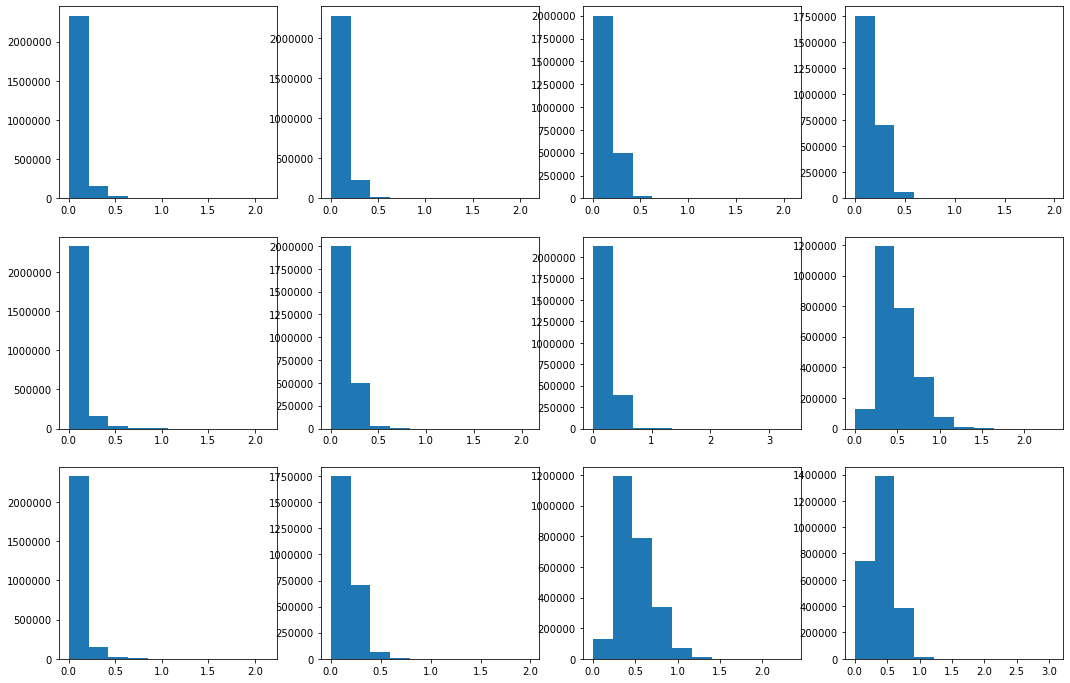

In [6]:
_, ax = plt.subplots(nrows=3, ncols=4, figsize=(18, 12))

for i in range(3):
    for j in range(4):
        ax[i][j].hist(tmp_data[:, (i+1)*j])

In [7]:
mean_ = data.mean(axis=1).mean(axis=0)
std_ = data.std(axis=1).std(axis=0)

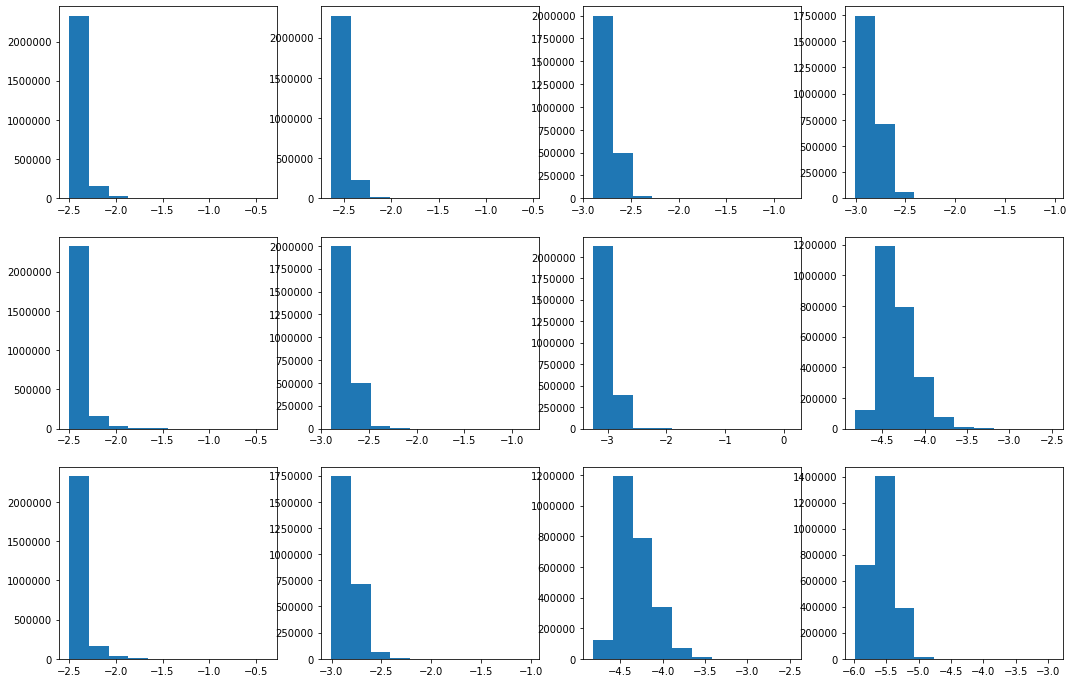

In [8]:
_, ax = plt.subplots(nrows=3, ncols=4, figsize=(18, 12))

tmp_data = tmp_data-mean_/std_

for i in range(3):
    for j in range(4):
        ax[i][j].hist(tmp_data[:, (i+1)*j])

In [9]:
def _generate_examples(pixels, lag=14, batch_size=32, start=0):
    """Generator of examples for each split."""
    while True:
        X_out = []
        y_out = []
        for i, pix in enumerate(pixels):
            mask = (masks[:, pix[0], pix[1]] == 0)
            vals = data[:, i+start, :][mask, :]
            date = dates[mask]
            

            if date.shape[0] <= lag:
                continue

            windows_ind = _roll(np.arange(date.shape[0]), lag + 1)
            for window in windows_ind:
                if vals[window[-1]].sum() == 0.:
                    continue
                X = vals[window]
#                 X = (X-mean_)/std_
                y = X[-1, :]
                X = X[:-1, :]
                date_diff = np.array([x.days/90 for x in (date[window][-1] - date[window][:-1])])
                X = np.hstack((date_diff.reshape(-1, 1), X))
                X_out.append(X)
                y_out.append(y)
                if len(X_out) == batch_size:
                    yield np.array(X_out) , np.array(y_out).reshape(batch_size, 12)
                    X_out.clear(), y_out.clear()

In [10]:
split_ind=int(0.7*pixels_ind.shape[0])
# split_ind=pixels_ind.shape[0]
BATCH_SIZE = 32
INPUT_SHAPE = (20, 13)

In [11]:
for x, y in _generate_examples(pixels_ind[:split_ind], lag=INPUT_SHAPE[0], batch_size=BATCH_SIZE):
    print(x.shape)
    print(y.shape)
    break

(32, 20, 13)
(32, 12)


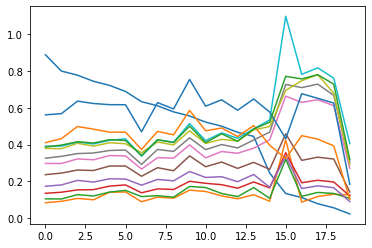

In [12]:
plt.plot(x[15, :, :]);

In [ ]:
model_cnn = tf.keras.Sequential([
    tf.keras.layers.Reshape(INPUT_SHAPE, input_shape=INPUT_SHAPE),
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=3,
                           activation='relu'),
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=3,
                           activation='relu'),
    tf.keras.layers.MaxPooling1D(2, strides=2),
    tf.keras.layers.Conv1D(filters=64,
                           kernel_size=3,
                           activation='relu'),
    tf.keras.layers.Conv1D(filters=64,
                           kernel_size=3,
                           activation='relu'),
    tf.keras.layers.MaxPooling1D(2, strides=2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=INPUT_SHAPE[1]-1),
])

model_cnn.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(),
              metrics=["mae"])

training_history_cnn = model_cnn.fit(_generate_examples(pixels_ind[:split_ind], lag=INPUT_SHAPE[0], batch_size=BATCH_SIZE),
          epochs=25, steps_per_epoch=int(pixels_ind[:split_ind].shape[0]/BATCH_SIZE),
          validation_data=_generate_examples(pixels_ind[split_ind:], lag=INPUT_SHAPE[0], batch_size=BATCH_SIZE, start=split_ind),
          validation_steps=int(split_ind/BATCH_SIZE),
         )

In [13]:
# model_cnn.save('models/cnn_model.h5')
# pickle.dump(training_history_cnn.history, open('models/training_history_cnn', 'wb'))
model_cnn = tf.keras.models.load_model('models/cnn_model.h5')

In [14]:
training_history_cnn = pickle.load(open('models/training_history_cnn', 'rb'))

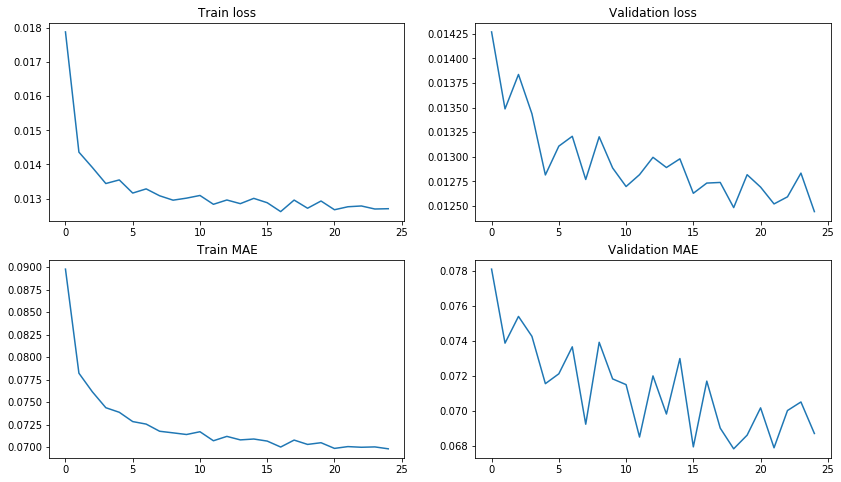

In [15]:
_, ax = plt.subplots(2, 2, figsize=(14, 8))
ax[0, 0].plot(training_history_cnn['loss'])
ax[0, 1].plot(training_history_cnn['val_loss'])
ax[1, 0].plot(training_history_cnn['mae'])
ax[1, 1].plot(training_history_cnn['val_mae'])

ax[0, 0].set_title('Train loss')
ax[0, 1].set_title('Validation loss')
ax[1, 0].set_title('Train MAE')
ax[1, 1].set_title('Validation MAE');

In [16]:
from sklearn.metrics import mean_absolute_error

In [17]:
def plot_predictions(model, pixel_index=None, lag=20):
    if pixel_index is None:
        pixel_index = np.random.randint(data_test.shape[1])
        
    y_true = []
    y_pred = []
    mae_ = []
    is_cloud = []
    
    mask = (masks[:, pixels_ind_test[pixel_index, 0], pixels_ind_test[pixel_index, 1]] != 1)
    vals = data_test[:, pixel_index, :][mask, :]
    date = dates[mask]
    clouds = masks[mask, pixels_ind_test[pixel_index, 0], pixels_ind_test[pixel_index, 1]]
    
    if date.shape[0] <= lag:
        return

    windows_ind = _roll(np.arange(date.shape[0]), lag + 1)
    for window in windows_ind:
        X = vals[window]
#         X = (X - mean_)/std_
        if clouds[window[-1]] == 1:
            continue
        y_true.append(X[-1, :])
        X = X[:-1, :]
        date_diff = np.array([x.days/90 for x in (date[window][-1] - date[window][:-1])])
        X = np.hstack((date_diff.reshape(-1, 1), X))
        y_pred.append(model.predict(X.reshape(1, INPUT_SHAPE[0], INPUT_SHAPE[1])).reshape(-1))
        mae_.append(mean_absolute_error(y_true[-1].reshape(-1), y_pred[-1]))
        is_cloud.append(clouds[window[-1]] == 2)
    
    return np.array(y_true), np.array(y_pred), np.array(mae_), np.array(is_cloud)

In [18]:
y_true, y_pred, mae_, is_cloud = plot_predictions(model_cnn)

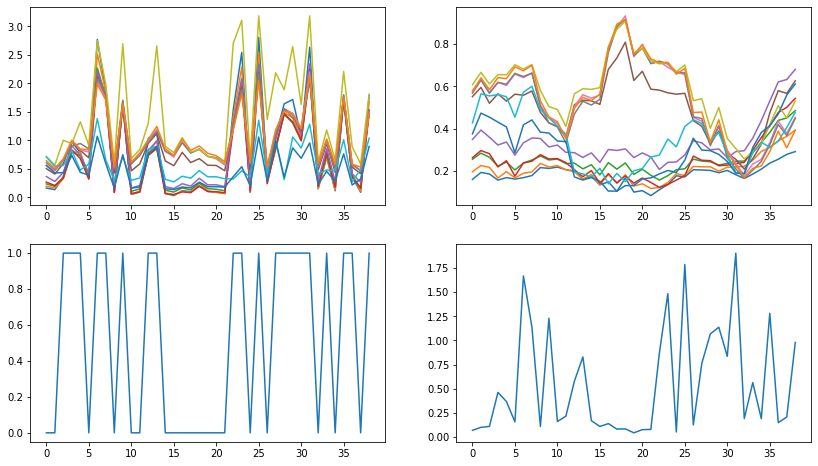

In [19]:
_, ax = plt.subplots(2, 2, figsize=(14, 8))
ax[0, 0].plot(y_true)
ax[0, 1].plot(y_pred)
ax[1, 0].plot(is_cloud)
ax[1, 1].plot(mae_);

In [20]:
INPUT_SHAPE = (20, 13)

In [21]:
bilstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(INPUT_SHAPE),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(units=12)
])

bilstm_model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(),
              metrics=[tf.metrics.MeanAbsoluteError()])

training_history_bilstm = bilstm_model.fit(
    _generate_examples(pixels_ind[:split_ind], lag=INPUT_SHAPE[0], batch_size=BATCH_SIZE),
    epochs=25, steps_per_epoch=int(pixels_ind[:split_ind].shape[0]/BATCH_SIZE),
    validation_data=_generate_examples(pixels_ind[split_ind:], lag=INPUT_SHAPE[0], batch_size=BATCH_SIZE,
                                       start=split_ind),
    validation_steps=int(split_ind/BATCH_SIZE)
)

Epoch 1/25
2187/2187 [==============================] - 40s 18ms/step - loss: 0.0145 - mean_absolute_error: 0.0783 - val_loss: 0.0133 - val_mean_absolute_error: 0.0729
Epoch 2/25
2187/2187 [==============================] - 40s 18ms/step - loss: 0.0136 - mean_absolute_error: 0.0741 - val_loss: 0.0129 - val_mean_absolute_error: 0.0703
Epoch 3/25
2187/2187 [==============================] - 41s 19ms/step - loss: 0.0132 - mean_absolute_error: 0.0720 - val_loss: 0.0133 - val_mean_absolute_error: 0.0742
Epoch 4/25
2187/2187 [==============================] - 41s 19ms/step - loss: 0.0128 - mean_absolute_error: 0.0708 - val_loss: 0.0128 - val_mean_absolute_error: 0.0704
Epoch 5/25
2187/2187 [==============================] - 42s 19ms/step - loss: 0.0130 - mean_absolute_error: 0.0704 - val_loss: 0.0124 - val_mean_absolute_error: 0.0683
Epoch 6/25
2187/2187 [==============================] - 41s 19ms/step - loss: 0.0126 - mean_absolute_error: 0.0693 - val_loss: 0.0126 - val_mean_absolute_error:

In [22]:
bilstm_model.save('models/bilstm_model.h5')
pickle.dump(training_history_bilstm.history, open('models/training_history_bilstm', 'wb'))

In [23]:
bilstm_model = tf.keras.models.load_model('models/bilstm_model.h5')
training_history_bilstm = pickle.load(open('models/training_history_bilstm', 'rb'))

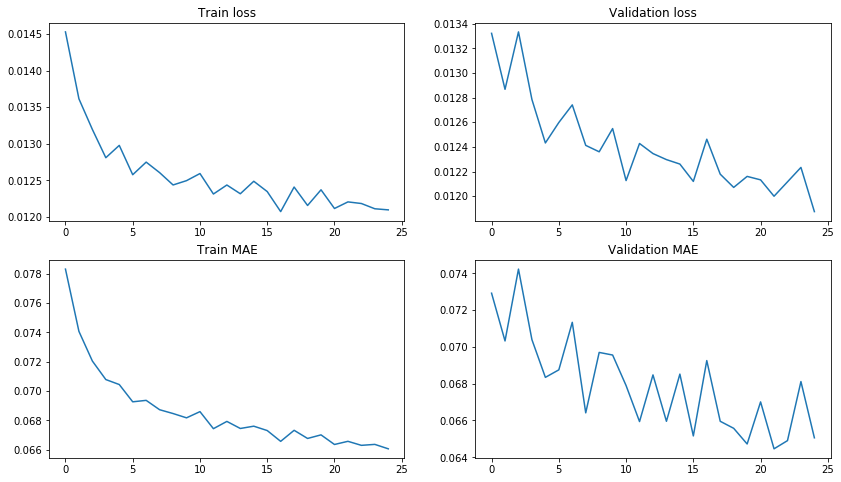

In [24]:
_, ax = plt.subplots(2, 2, figsize=(14, 8))
ax[0, 0].plot(training_history_bilstm['loss'])
ax[0, 1].plot(training_history_bilstm['val_loss'])
ax[1, 0].plot(training_history_bilstm['mean_absolute_error'])
ax[1, 1].plot(training_history_bilstm['val_mean_absolute_error'])

ax[0, 0].set_title('Train loss')
ax[0, 1].set_title('Validation loss')
ax[1, 0].set_title('Train MAE')
ax[1, 1].set_title('Validation MAE');

In [25]:
y_true, y_pred, mae_, is_cloud = plot_predictions(bilstm_model)

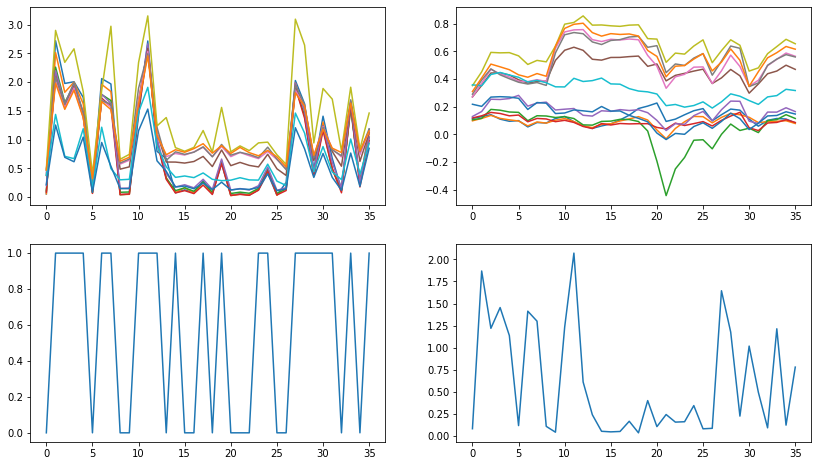

In [26]:
_, ax = plt.subplots(2, 2, figsize=(14, 8))
ax[0, 0].plot(y_true)
ax[0, 1].plot(y_pred)
ax[1, 0].plot(is_cloud)
ax[1, 1].plot(mae_);